#Average IR SED binned by $L_{14-195\,keV}$

In [4]:
# Standard module imports
import numpy as np
import scipy.stats as stats
import pandas as pd
import sys
%matplotlib inline

# Useful directories
gh_dir = '/Users/ttshimiz/Github/'
sed_fit_dir = gh_dir + 'bat-agn-sed-fitting/'
casey_dir = sed_fit_dir + 'analysis/casey_bayes_results/'
data_dir = gh_dir + 'bat-data/'

In [5]:
# Setup the figures
execfile('../code/figure-setup.py')

In [19]:
# Upload the info for the BAT AGN (i.e. AGN type, luminosity distance, redshift, etc)
bat_info = pd.read_csv(data_dir+'bat_info.csv', index_col=0)
bat_info.loc['UGC06728', 'Dist_[Mpc]'] = 292.0

bat_flux = pd.read_csv(data_dir+'bat_bat_flux.csv', index_col=0)
bat_flux['bat_flux_err_low'] = bat_flux['BAT_flux'] - bat_flux['BAT_flux_90_low']
bat_flux['bat_flux_err_high'] = bat_flux['BAT_flux_90_high'] - bat_flux['BAT_flux']
bat_flux['lbat'] = np.log10(4*np.pi*(bat_info['Dist_[Mpc]']*10**6*3.09e18)**2*bat_flux['BAT_flux']*10**(-12))

# Upload the IR photometry
bat_herschel = pd.read_csv(data_dir+'bat_herschel.csv', index_col=0)
bat_wise = pd.read_csv(data_dir+'bat_wise.csv', index_col=0)


In [20]:
# Remove the radio loud sources and Mrk 3
# Remove 'bad' sources
radio_loud_sources = np.array(['PICTORA', '3C111.0', '3C120',
                              '2MASXJ23272195+1524375', 'PKS2331-240',
                              'HB890241+622', 'Mrk3'])

bat_flux = bat_flux.drop(radio_loud_sources)
bat_herschel = bat_herschel.drop(radio_loud_sources)
bat_wise = bat_wise.drop(radio_loud_sources)

In [10]:
# Import the ASURV package
sys.path.append(gh_dir+'asurv/')
import asurv

In [180]:
# Define the Lx bins and count the number of sources in each
bin_1 = bat_flux['lbat'] <= 42.5
bin_2 = (bat_flux['lbat'] > 42.5) & (bat_flux['lbat'] <= 43.0)
bin_3 = (bat_flux['lbat'] > 43.0) & (bat_flux['lbat'] <= 43.5)
bin_4 = (bat_flux['lbat'] > 43.5) & (bat_flux['lbat'] <= 44.0)
bin_5 = (bat_flux['lbat'] > 44.0)

print '# in Bin 1: ', sum(bin_1)
print '# in Bin 2: ', sum(bin_2)
print '# in Bin 3: ', sum(bin_3)
print '# in Bin 4: ', sum(bin_4)
print '# in Bin 5: ', sum(bin_5)

# in Bin 1:  23
# in Bin 2:  39
# in Bin 3:  94
# in Bin 4:  116
# in Bin 5:  34


In [194]:
bin_edges = np.array([42.5, 43.0, 43.5, 44.0])
n_bins = len(bin_edges) + 1
wavebands = ['W1', 'W2', 'W3', 'W4', 'PACS70', 'PACS160', 'PSW', 'PMW', 'PLW']
sed = bat_herschel.join(bat_wise)
norm_band = 'W3'
binned_seds = pd.DataFrame(index=np.arange(n_bins),
                           columns=wavebands)
binned_seds_err_up = pd.DataFrame(index=np.arange(n_bins),
                                  columns=wavebands)
binned_seds_err_down = pd.DataFrame(index=np.arange(n_bins),
                                    columns=wavebands)

for i in range(n_bins):
    
    if i == 0:
        ind = bat_flux['lbat'] <= bin_edges[i]
    elif i == (n_bins - 1):
        ind = bat_flux['lbat'] > bin_edges[-1]
    else:
        ind = (bat_flux['lbat'] > bin_edges[i-1]) & (bat_flux['lbat'] <= bin_edges[i])
    
    norm_f = sed.loc[ind, norm_band].values
    for w in wavebands:
        
        f = sed.loc[ind, w].values
        ferr = sed.loc[ind, w+'_err'].values
        ul = f == 0
        f[ul] = ferr[ul]
        data = f/norm_f
        cens= np.ones(len(data))
        cens[ul] = 0
        
        km = asurv.KaplanMeierDist(data=data, cens=cens)
        med = km.km_percentile(0.5)
        p16 = km.km_percentile(0.16)
        p84 = km.km_percentile(0.84)
        
        binned_seds.loc[i, w] = med
        binned_seds_err_down.loc[i, w] = med-p16
        binned_seds_err_up.loc[i, w] = p84-med

binned_seds[norm_band] = 1
binned_seds_err_up[norm_band] = 0
binned_seds_err_down[norm_band] = 0

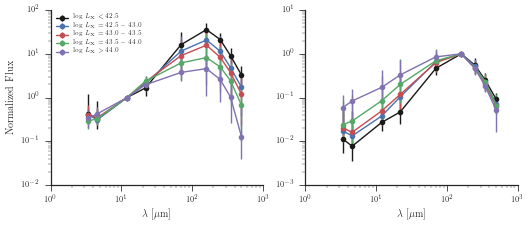

In [199]:
ll = np.array([3.4, 4.6, 12., 22., 70., 160., 250, 350., 500.])

fig = plt.figure(figsize=(1.2*textwidth, 1.2*3./8*textwidth))
ax1 = fig.add_subplot(121)
ax1.errorbar(ll, binned_seds.loc[0], yerr=np.vstack([binned_seds_err_down.loc[0], binned_seds_err_up.loc[0]]),
             fmt='o', color='k', ls='-', label=r'$\log\,L_{\rm X} < 42.5$')
ax1.errorbar(ll, binned_seds.loc[1], yerr=np.vstack([binned_seds_err_down.loc[1], binned_seds_err_up.loc[1]]),
             fmt='o', color='b', ls='-', label=r'$\log\,L_{\rm X} = 42.5-43.0$')
ax1.errorbar(ll, binned_seds.loc[2], yerr=np.vstack([binned_seds_err_down.loc[2], binned_seds_err_up.loc[2]]),
             fmt='o', color='r', ls='-', label=r'$\log\,L_{\rm X} = 43.0-43.5$')
ax1.errorbar(ll, binned_seds.loc[3], yerr=np.vstack([binned_seds_err_down.loc[3], binned_seds_err_up.loc[3]]),
             fmt='o', color='g', ls='-', label=r'$\log\,L_{\rm X} = 43.5-44.0$')
ax1.errorbar(ll, binned_seds.loc[4], yerr=np.vstack([binned_seds_err_down.loc[4], binned_seds_err_up.loc[4]]),
             fmt='o', color='m', ls='-', label=r'$\log\,L_{\rm X} > 44.0$')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.legend(loc='upper left', fontsize=6)
ax1.set_ylabel('Normalized Flux')
ax1.set_xlabel('$\lambda$ [$\mu$m]')

ax2 = fig.add_subplot(122)
ax2.errorbar(ll, binned_seds2.loc[0], yerr=np.vstack([binned_seds2_err_down.loc[0], binned_seds2_err_up.loc[0]]),
             fmt='o', color='k', ls='-', label=r'$\log\,L_{\rm X} < 42.5$')
ax2.errorbar(ll, binned_seds2.loc[1], yerr=np.vstack([binned_seds2_err_down.loc[1], binned_seds2_err_up.loc[1]]),
             fmt='o', color='b', ls='-', label=r'$\log\,L_{\rm X} = 42.5-43.0$')
ax2.errorbar(ll, binned_seds2.loc[2], yerr=np.vstack([binned_seds2_err_down.loc[2], binned_seds2_err_up.loc[2]]),
             fmt='o', color='r', ls='-', label=r'$\log\,L_{\rm X} = 43.0-43.5$')
ax2.errorbar(ll, binned_seds2.loc[3], yerr=np.vstack([binned_seds2_err_down.loc[3], binned_seds2_err_up.loc[3]]),
             fmt='o', color='g', ls='-', label=r'$\log\,L_{\rm X} = 43.5-44.0$')
ax2.errorbar(ll, binned_seds2.loc[4], yerr=np.vstack([binned_seds2_err_down.loc[4], binned_seds2_err_up.loc[4]]),
             fmt='o', color='m', ls='-', label=r'$\log\,L_{\rm X} > 44.0$')
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('$\lambda$ [$\mu$m]')
sn.despine()

fig.savefig(figsave_dir+'avg_sed_binned_lx.pdf', bbox_inches='tight')

In [192]:
binned_seds2

,W1,W2,W3,W4,PACS70,PACS160,PSW,PMW,PLW
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<module 'asurv' from '/Users/ttshimiz/Github/asurv/asurv.py'>

(1.0657236084239301, 0.15534224123102661)

In [122]:
km.ndetect

22.0